# Clarissa Finder

In this project, we are going to harness the power of convolutional neural networks (with Keras) to build a system that detects my fiance, Clarissa. To do this, we will aggregate all photos of her into a training, validation, and test set. Then, we will upload photos without her into the same three sets. In essence, this is a binary classification problem, but the main challenge will be that we don't have too much data containing Clarissa pictures. 

We will use methods found in this article to upsample the data: https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6. Then, we will compare performance of pretrained models vs. scratch models.

In [1]:
import os
from PIL import Image
from PIL import ImageFilter
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications.vgg19 import VGG19
np.random.seed(123)

Using TensorFlow backend.


First we need to create a train, test, and validation set. We can do this using code modified from https://stackoverflow.com/questions/53074712/how-to-split-folder-of-images-into-test-training-validation-sets-with-stratified/53585684#53585684?newreg=e82255fe75f64de6864a84cedc14f6bc. We only need to run this cell once.

In [162]:
def get_tvt_split():
    # # Creating Train / Val / Test folders (One time use)
    root_dir = 'data'
    posCls = '/clarissa'
    negCls = '/non_clarissa'

    os.makedirs(root_dir +'/train' + posCls)
    os.makedirs(root_dir +'/train' + negCls)
    os.makedirs(root_dir +'/val' + posCls)
    os.makedirs(root_dir +'/val' + negCls)
    os.makedirs(root_dir +'/test' + posCls)
    os.makedirs(root_dir +'/test' + negCls)

    # Creating partitions of the data after shuffeling
    for currentCls in [posCls, negCls]:
        src = "data" + currentCls # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, "data/train"+currentCls)

        for name in val_FileNames:
            shutil.copy(name, "data/val"+currentCls)

        for name in test_FileNames:
            shutil.copy(name, "data/test"+currentCls)


In [163]:
# Only run this once!
#get_tvt_split()

We only have a little over 500 photos of Clarissa. To deal with this problem, we are going to upsample our training data by adding blurry and unsharpened versions of each picture in our data set. Running the code below does this. Note we only need to do this once! Be careful since this takes a long time. By the end of this process, we have quintupled our dataset!

In [164]:
def upsample_data():
    count = 0
    filelist = os.listdir('data/train/clarissa')
    os.chdir('data/train/clarissa')
    for imagefile in filelist:
        im = Image.open(imagefile)
        im = im.convert("RGB")
        im_blur = im.filter(ImageFilter.GaussianBlur)
        im_unsharp = im.filter(ImageFilter.UnsharpMask)
        im_blur.save(str(count) + 'bl_' + imagefile)
        im_unsharp.save(str(count) + 'un_' + imagefile)

In [165]:
# Only run this once!
#upsample_data()

In [4]:
# Note we are in train folder

print(len(os.listdir('data/train/clarissa')))

1098


In [5]:
print(len(os.listdir('data/train/non_clarissa')))

1014


Okay, now we have roughly the same number of Clarissa and non-Clarissa photos for training. Note that upsampling is not a sure way to improve performance, but in our case it's necessary due to lack of training examples. Let's print a few of our training examples (note we also have some childhood pictures)!

In [6]:
os.chdir('data/train/clarissa')

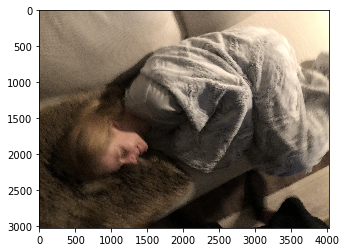

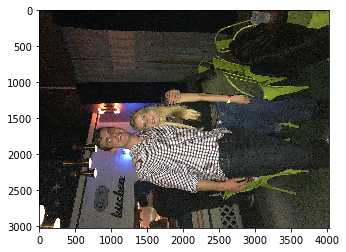

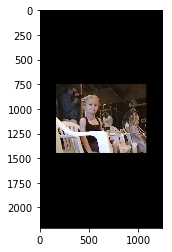

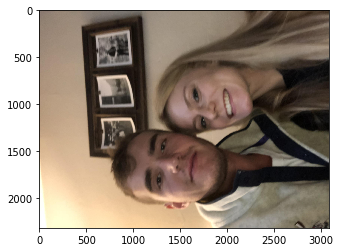

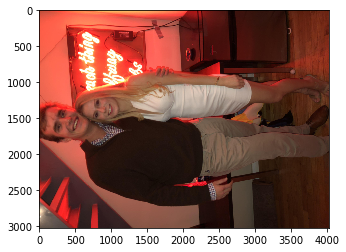

In [7]:
for pic_file in  np.random.choice(os.listdir(), 5):
    img = mpimg.imread(pic_file)
    plt.imshow(img)
    plt.show()

In [8]:
os.chdir('../non_clarissa')

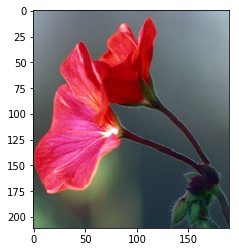

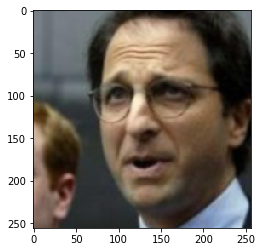

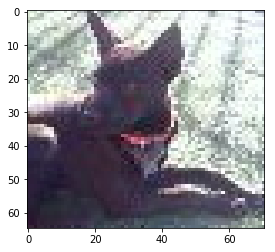

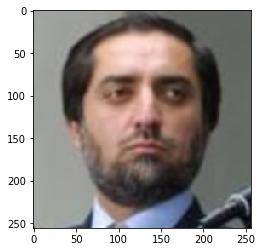

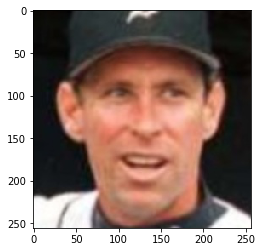

In [14]:
for pic_file in np.random.choice(os.listdir(), 5):
    img = mpimg.imread(pic_file)
    plt.imshow(img)
    plt.show()

As you can see, our non_clarissa data is random data from the internet, as well as pictures from my phone which do not contain her. Many are pictures of people's faces, fruit, airplanes, and cars sourced from Kaggle's ImageNet competition dataset. Let's go back into our main folder.

In [15]:
os.chdir('../../..')

In [16]:
print(os.getcwd())

C:\Users\rcapu\OneDrive\Documents\Shared\photo_data


Now, we are ready to try out some models. We are going to train images uniformly as 228 by 228. We can get away with larger dimensional training since our dataset is small and we are running tensorflow on gpu. Let's start with a small convnet. 

## Model Building

### Small Convnet

For this convnet, we will use a basic 3 layer convolutional network followed by a small dense layer. Additionally, we perform max pooling in between convolutional layers. By starting with a simple model, we can determine a baseline score to measure more complex models against. Note that for training purposes, we will add horizontal flips to our images, as adding adversity usually improves validation / test performance.

In [35]:
# Get model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(228, 228, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

In [36]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [45]:
# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 226, 226, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 226, 226, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 113, 113, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 111, 111, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 111, 111, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 53, 53, 64)        18496     
__________

In [37]:
# Get data generators

batch_size = 16
target_size = (228, 228)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=target_size,  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 2112 images belonging to 2 classes.
Found 296 images belonging to 2 classes.


We will use early stopping to prevent overfitting. By setting patience to 7, we keep a model once it has stopped improving on validation accuracy after 7 epochs. This gives the model a solid chance of finding improvements without overfitting.

In [38]:
from keras.callbacks import EarlyStopping

# Keep only best weights after 7 epochs of no val_acc improvement
callback = EarlyStopping(
    monitor='val_acc', 
    restore_best_weights=True,
    patience=7
)

In [39]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2112 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=296 // batch_size,
        callbacks=[callback]
)
os.mkdir('models')
model.save('models/model_01.h5')  # always save your weights after training or during training

Epoch 1/50
132/132 [==============================] - 173s 1s/step - loss: 0.5276 - acc: 0.7562 - val_loss: 0.4045 - val_acc: 0.8021
Epoch 2/50
132/132 [==============================] - 175s 1s/step - loss: 0.3867 - acc: 0.8381 - val_loss: 0.2784 - val_acc: 0.8714
Epoch 3/50
132/132 [==============================] - 166s 1s/step - loss: 0.3671 - acc: 0.8565 - val_loss: 0.3817 - val_acc: 0.7964
Epoch 4/50
132/132 [==============================] - 172s 1s/step - loss: 0.3112 - acc: 0.8797 - val_loss: 0.3600 - val_acc: 0.8679
Epoch 5/50
132/132 [==============================] - 183s 1s/step - loss: 0.2991 - acc: 0.8897 - val_loss: 0.7639 - val_acc: 0.7964
Epoch 6/50
132/132 [==============================] - 176s 1s/step - loss: 0.3104 - acc: 0.8982 - val_loss: 0.6663 - val_acc: 0.8107
Epoch 7/50
132/132 [==============================] - 179s 1s/step - loss: 0.2966 - acc: 0.8944 - val_loss: 0.6498 - val_acc: 0.8179
Epoch 8/50
132/132 [==============================] - 175s 1s/step - 

As we can see, our validation accuracy maxed out at 92%. This is quite good for a first attempt, especially since our training set is small. Let's examine some validation predictions.

Found 296 images belonging to 2 classes.
Clarissa!


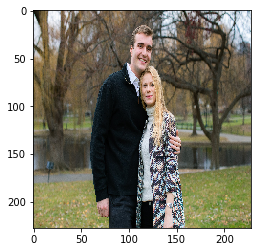


Not Clarissa!


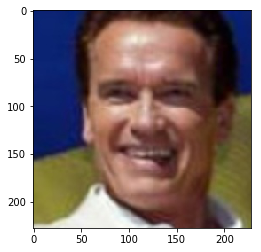


Not Clarissa!


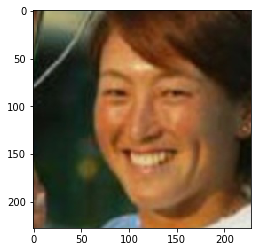


Not Clarissa!


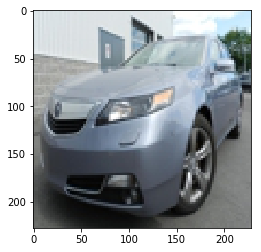


Clarissa!


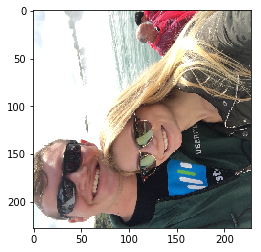


Not Clarissa!


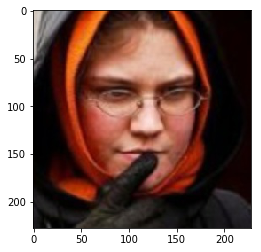


Not Clarissa!


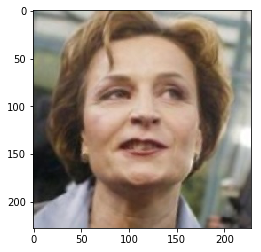


Not Clarissa!


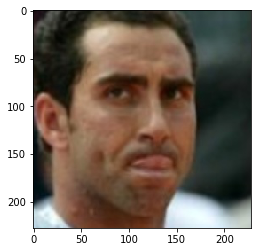


Not Clarissa!


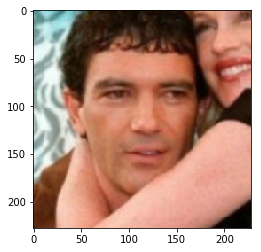


Not Clarissa!


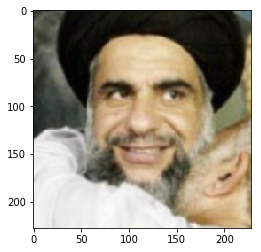

In [41]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=target_size,
        batch_size=1,
        class_mode='binary')

for _ in range(10):
    x = next(validation_generator)[0]
    print('Clarissa!' if model.predict(x)[0][0] < 0.5 else 'Not Clarissa!')
    plt.imshow(x.reshape((228, 228, 3)))
    plt.show()
    print()
    

We can see that our small convnet accurately labeled these 10 pictures.

Let's also plot our model training performance.

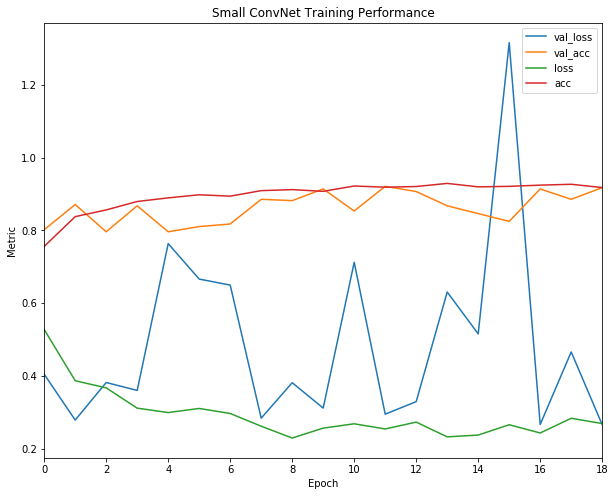

In [47]:
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title('Small ConvNet Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

It seems that our validation loss was quite stochastic, meaning that each epoch significantly affected model performance on unseen data. It is difficult to say whether or not training more would significantly improve model performance or lead to overfitting. Nonetheless, this is a great start.

Let's now move to using a more advanced network, i.e. one that has pretrained layers. This is a very helpful technique since a pre-trained algorithm already has a very good general understanding of what defines an image in terms of shape, color, and structure. This is mainly because these pre-trained networks are usually very deep and have been trained on millions of diverse images with complex classification tasks. By extracting the general structure of these networks without training them further, we can append a small Dense network to learn how the network represents a Clarissa vs. non-Clarissa picture in hopes that this new model will perform better than a scratch-built model. 

We will be sourcing from VGG19, the latest trained ImageNet network, and freezing its initial layers.

## Pretrained Model

In [40]:
# build the VGG16 network
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
print('Model loaded.')
print(cnn_base.summary())


Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0      

We can see that this is a very large model. Let's now run our data through this model to save our 'bottlenecked features.' We will use the default 224 by 224 image size which was used to formulate the original VGG model. After saving these predictions, we can build a final dense layer for our classification task.

In [6]:
batch_size = 16
nb_train_samples = 2112 
nb_validation_samples = 296 
nb_test_samples = len(os.listdir('data/test/clarissa')) + len(os.listdir('data/test/non_clarissa'))

def extract_features(directory, sample_amount):
    """ Get's features and labels"""
    features = np.zeros(shape=(sample_amount, 7, 7, 512)) 
    labels = np.zeros(shape=(sample_amount))
    datagen = ImageDataGenerator(rescale=1./255) 
    generator = datagen.flow_from_directory(
        directory, target_size=(224, 224), 
        batch_size = batch_size, 
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = cnn_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [66]:
train_folder = 'data/train'
val_folder = 'data/val'
test_folder = 'data/test'

train_features, train_labels = extract_features(train_folder, nb_train_samples) 
validation_features, validation_labels = extract_features(val_folder, nb_validation_samples) 
test_features, test_labels = extract_features(test_folder, nb_test_samples)

reshape_y = 7 * 7 * 512
train_features = np.reshape(train_features, (nb_train_samples, reshape_y))
validation_features = np.reshape(validation_features, (nb_validation_samples, reshape_y))
test_features = np.reshape(test_features, (nb_test_samples, reshape_y))

Found 2112 images belonging to 2 classes.
Found 296 images belonging to 2 classes.
Found 297 images belonging to 2 classes.


In [140]:
## Save features and labels
# os.mkdir('data/bottlenecked')
# np.save('data/bottlenecked/train_features.npy', train_features)
# np.save('data/bottlenecked/train_labels.npy', train_labels)
# np.save('data/bottlenecked/validation_features.npy', validation_features)
# np.save('data/bottlenecked/validation_labels.npy', validation_labels)
# np.save('data/bottlenecked/test_features.npy', test_features)
# np.save('data/bottlenecked/test_labels.npy', test_labels)

In [71]:
# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=reshape_y))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))
model.save('models/model_VGG_01.h5')

Train on 2112 samples, validate on 296 samples
Epoch 1/20
2112/2112 [==============================] - 2s 1ms/step - loss: 0.2685 - acc: 0.9001 - val_loss: 0.1486 - val_acc: 0.9392
Epoch 2/20
2112/2112 [==============================] - 1s 702us/step - loss: 0.1098 - acc: 0.9588 - val_loss: 0.1531 - val_acc: 0.9561
Epoch 3/20
2112/2112 [==============================] - 1s 685us/step - loss: 0.0482 - acc: 0.9825 - val_loss: 0.3513 - val_acc: 0.9088
Epoch 4/20
2112/2112 [==============================] - 2s 718us/step - loss: 0.0319 - acc: 0.9882 - val_loss: 0.1621 - val_acc: 0.9426
Epoch 5/20
2112/2112 [==============================] - 1s 701us/step - loss: 0.0174 - acc: 0.9929 - val_loss: 0.1544 - val_acc: 0.9426
Epoch 6/20
2112/2112 [==============================] - 1s 680us/step - loss: 0.0161 - acc: 0.9957 - val_loss: 0.1989 - val_acc: 0.9426
Epoch 7/20
2112/2112 [==============================] - 1s 684us/step - loss: 0.0061 - acc: 0.9981 - val_loss: 0.1963 - val_acc: 0.9392
Epo

Wow, close to a 5% improvement in validation accuracy! Let's print training history.

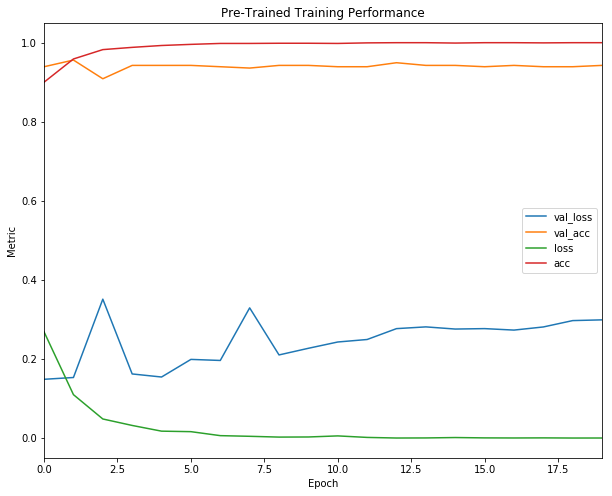

In [72]:
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title('Pre-Trained Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

It's clear that our validation loss did not continue to improve after the initial epochs. We can tune our hyperparameters to try and improve how the model trains over time. Let's now print some validation predictions! To do this, we will grab the corresponding bottlenecked features and predict using our final two dense layers.

In [169]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=(224, 224),
        batch_size=10,
        class_mode='binary')
i = 0

Found 296 images belonging to 3 classes.


Not Clarissa!


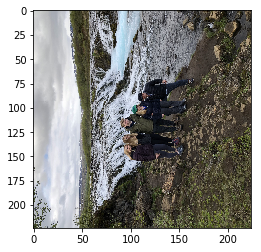


Clarissa!


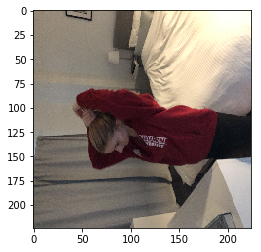


Not Clarissa!


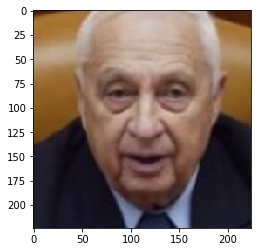


Clarissa!


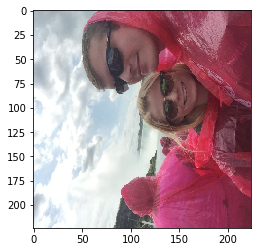


Not Clarissa!


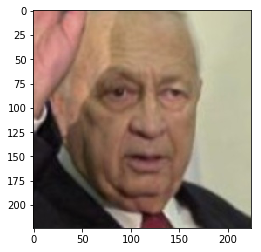


Not Clarissa!


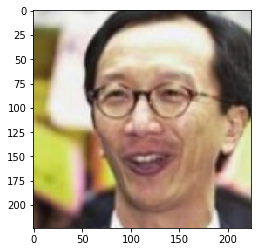


Clarissa!


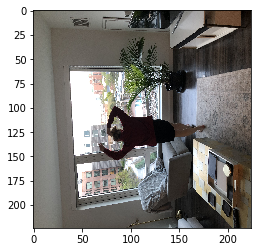


Not Clarissa!


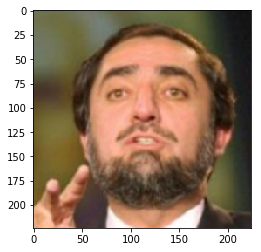


Clarissa!


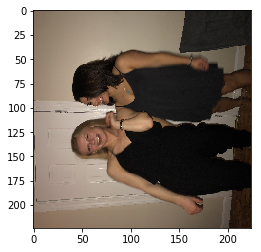


Not Clarissa!


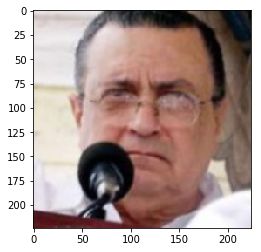

In [168]:
# We can run this cell until we use up each val image
# prints 10 images at a time
x = next(validation_generator)
for i in range(i, i + 10):
    cnn_pred = cnn_base.predict(x[0][i%10].reshape(1, 224, 224, 3)).flatten().reshape(1, -1)
    print('Clarissa!' if model.predict(cnn_pred) < 0.5 else 'Not Clarissa!')
    plt.imshow(x[0][i%10].reshape((224, 224, 3)))
    plt.show()
    print()
i += 10

## Model Validation and Hyperparameter Tuning

This model was only incorrect on the first image, which is difficult due to the distance. It seems as though the pretrained model performed quite well, and far better than the scratch model on the validation set. Let's now tune our pretrained models hyperparameters, i.e., the number of final hidden layers as well as different optimizers. Since we have already run the data through VGG, we can train and validate new models very quickly. Since the pretrained model is already greatly exceeding the performance of the scratch model already, and because training pretrained models is much faster, we will focus solely on optimizing the pretrained model.

In [3]:
# First, reload data
train_features = np.load('data/bottlenecked/train_features.npy')
train_labels = np.load('data/bottlenecked/train_labels.npy')
validation_features = np.load('data/bottlenecked/validation_features.npy')
validation_labels = np.load('data/bottlenecked/validation_labels.npy')

In [4]:
train_features.shape

(2112, 25088)

Recall that in our previous model, we used a single dense layer of size 256 with relu activation followed by a single sigmoid activation. Now, let's try a slightly deeper network and add in a single dropout layer. To keep track of count, we simply add a count variable. This will help with saving and plotting.

In [13]:
count = 2

Train on 2112 samples, validate on 296 samples
Epoch 1/20
2112/2112 [==============================] - 2s 1ms/step - loss: 0.3299 - acc: 0.8679 - val_loss: 0.2240 - val_acc: 0.9088
Epoch 2/20
2112/2112 [==============================] - 1s 703us/step - loss: 0.1077 - acc: 0.9574 - val_loss: 0.1271 - val_acc: 0.9595
Epoch 3/20
2112/2112 [==============================] - 1s 699us/step - loss: 0.0760 - acc: 0.9716 - val_loss: 0.2005 - val_acc: 0.9392
Epoch 4/20
2112/2112 [==============================] - 1s 708us/step - loss: 0.0478 - acc: 0.9830 - val_loss: 0.1573 - val_acc: 0.9527
Epoch 5/20
2112/2112 [==============================] - 1s 698us/step - loss: 0.0279 - acc: 0.9891 - val_loss: 0.1745 - val_acc: 0.9493
Epoch 6/20
2112/2112 [==============================] - 1s 707us/step - loss: 0.0105 - acc: 0.9967 - val_loss: 0.2024 - val_acc: 0.9392
Epoch 7/20
2112/2112 [==============================] - 1s 704us/step - loss: 0.0123 - acc: 0.9948 - val_loss: 0.2399 - val_acc: 0.9392
Epo

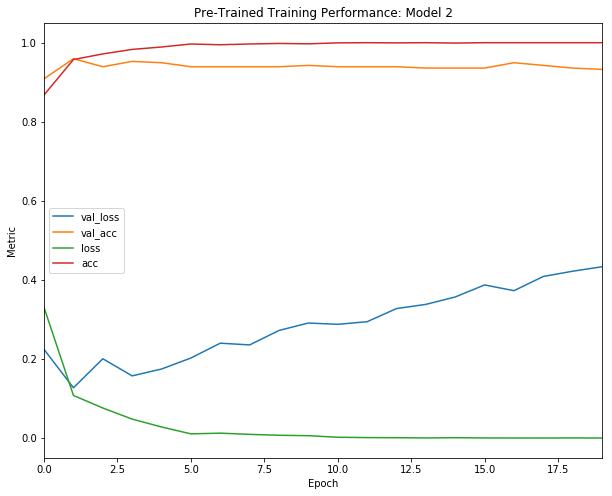

In [14]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))
model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')
count += 1
plt.show()

Here, our model performs better than in the first model in terms of validation accuracy and loss, but begins to overfit by the last few epochs. Let's try reducing the learning rate.

Train on 2112 samples, validate on 296 samples
Epoch 1/20
2112/2112 [==============================] - 2s 1ms/step - loss: 0.3687 - acc: 0.8461 - val_loss: 0.2071 - val_acc: 0.9223
Epoch 2/20
2112/2112 [==============================] - 1s 701us/step - loss: 0.1864 - acc: 0.9276 - val_loss: 0.2309 - val_acc: 0.8986
Epoch 3/20
2112/2112 [==============================] - 1s 705us/step - loss: 0.1331 - acc: 0.9569 - val_loss: 0.1384 - val_acc: 0.9426
Epoch 4/20
2112/2112 [==============================] - 1s 700us/step - loss: 0.1002 - acc: 0.9730 - val_loss: 0.1348 - val_acc: 0.9392
Epoch 5/20
2112/2112 [==============================] - 1s 708us/step - loss: 0.0768 - acc: 0.9773 - val_loss: 0.1463 - val_acc: 0.9392
Epoch 6/20
2112/2112 [==============================] - 2s 718us/step - loss: 0.0660 - acc: 0.9806 - val_loss: 0.1431 - val_acc: 0.9358
Epoch 7/20
2112/2112 [==============================] - 1s 692us/step - loss: 0.0538 - acc: 0.9863 - val_loss: 0.1238 - val_acc: 0.9358
Epo

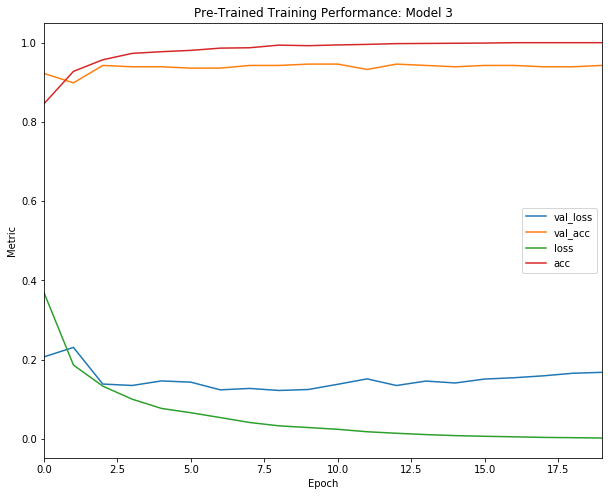

In [15]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))
model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')
count += 1
plt.show()

That's even better! Let's try reducing even a little further.

Train on 2112 samples, validate on 296 samples
Epoch 1/20
2112/2112 [==============================] - 2s 1ms/step - loss: 0.4507 - acc: 0.8130 - val_loss: 0.3657 - val_acc: 0.8378
Epoch 2/20
2112/2112 [==============================] - 1s 694us/step - loss: 0.2601 - acc: 0.8968 - val_loss: 0.2199 - val_acc: 0.8919
Epoch 3/20
2112/2112 [==============================] - 1s 700us/step - loss: 0.1941 - acc: 0.9280 - val_loss: 0.1899 - val_acc: 0.9155
Epoch 4/20
2112/2112 [==============================] - 1s 704us/step - loss: 0.1518 - acc: 0.9474 - val_loss: 0.1752 - val_acc: 0.9223
Epoch 5/20
2112/2112 [==============================] - 2s 728us/step - loss: 0.1275 - acc: 0.9588 - val_loss: 0.1742 - val_acc: 0.9223
Epoch 6/20
2112/2112 [==============================] - 2s 713us/step - loss: 0.1069 - acc: 0.9650 - val_loss: 0.1496 - val_acc: 0.9358
Epoch 7/20
2112/2112 [==============================] - 2s 714us/step - loss: 0.0907 - acc: 0.9730 - val_loss: 0.1613 - val_acc: 0.9223
Epo

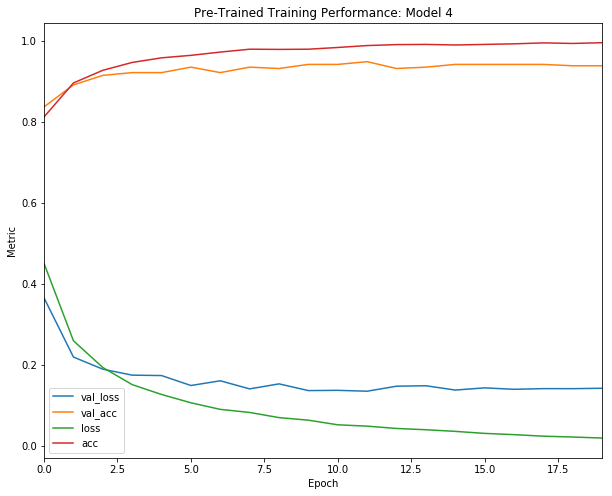

In [16]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=5e-6),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))
model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')
count += 1
plt.show()

Reducing the LR further makes our plot look nice, but notice that this time our model did not achieve as low a loss as before. As a check, let's try using a different optimizer, in particular, the adam optimizer. This optimizer performs very well on a wide array of problems, so it's worth trying here. 

Train on 2112 samples, validate on 296 samples
Epoch 1/20
2112/2112 [==============================] - 3s 1ms/step - loss: 0.3181 - acc: 0.8868 - val_loss: 0.1446 - val_acc: 0.9561
Epoch 2/20
2112/2112 [==============================] - 2s 750us/step - loss: 0.0660 - acc: 0.9787 - val_loss: 0.1358 - val_acc: 0.9561
Epoch 3/20
2112/2112 [==============================] - 2s 761us/step - loss: 0.0343 - acc: 0.9872 - val_loss: 0.1586 - val_acc: 0.9595
Epoch 4/20
2112/2112 [==============================] - 2s 761us/step - loss: 0.0182 - acc: 0.9943 - val_loss: 0.1809 - val_acc: 0.9459
Epoch 5/20
2112/2112 [==============================] - 2s 760us/step - loss: 0.0133 - acc: 0.9957 - val_loss: 0.1644 - val_acc: 0.9459
Epoch 6/20
2112/2112 [==============================] - 2s 763us/step - loss: 0.0259 - acc: 0.9901 - val_loss: 0.2124 - val_acc: 0.9324
Epoch 7/20
2112/2112 [==============================] - 2s 749us/step - loss: 0.0147 - acc: 0.9943 - val_loss: 0.2389 - val_acc: 0.9392
Epo

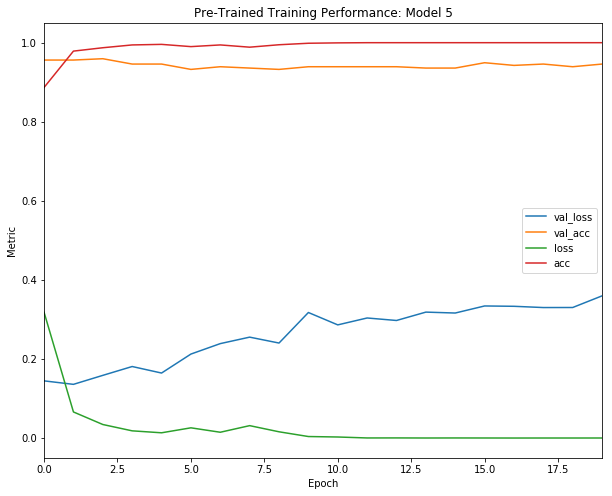

In [17]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))
model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')
count += 1
plt.show()

It seems adam did not train as well as RMSprop. Let's try a deeper model (with the same other hyperparameters as model 4) and see if there's any benefit over a shallow network. 

Train on 2112 samples, validate on 296 samples
Epoch 1/20
2112/2112 [==============================] - 2s 1ms/step - loss: 0.5444 - acc: 0.7424 - val_loss: 0.3629 - val_acc: 0.8514
Epoch 2/20
2112/2112 [==============================] - 2s 726us/step - loss: 0.3418 - acc: 0.8769 - val_loss: 0.2579 - val_acc: 0.8986
Epoch 3/20
2112/2112 [==============================] - 2s 726us/step - loss: 0.2417 - acc: 0.9134 - val_loss: 0.2114 - val_acc: 0.9122
Epoch 4/20
2112/2112 [==============================] - 2s 727us/step - loss: 0.2024 - acc: 0.9285 - val_loss: 0.1900 - val_acc: 0.9155
Epoch 5/20
2112/2112 [==============================] - 2s 727us/step - loss: 0.1673 - acc: 0.9408 - val_loss: 0.1715 - val_acc: 0.9223
Epoch 6/20
2112/2112 [==============================] - 2s 722us/step - loss: 0.1522 - acc: 0.9474 - val_loss: 0.1548 - val_acc: 0.9291
Epoch 7/20
2112/2112 [==============================] - 2s 719us/step - loss: 0.1252 - acc: 0.9583 - val_loss: 0.1667 - val_acc: 0.9257
Epo

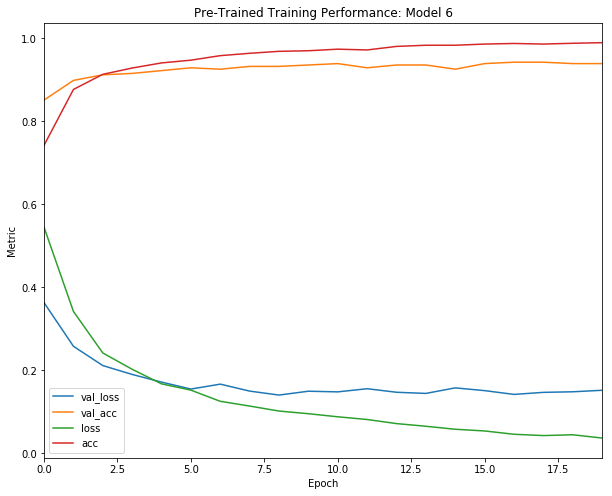

In [18]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=5e-6),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))
model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')
count += 1
plt.show()

This model doesn't perform quite as well as the two layer model with the same learning rate. Let's try a shallower network.

Train on 2112 samples, validate on 296 samples
Epoch 1/20
2112/2112 [==============================] - 2s 1ms/step - loss: 0.4510 - acc: 0.8092 - val_loss: 0.2870 - val_acc: 0.8818
Epoch 2/20
2112/2112 [==============================] - 1s 696us/step - loss: 0.2462 - acc: 0.9119 - val_loss: 0.2553 - val_acc: 0.8919
Epoch 3/20
2112/2112 [==============================] - 1s 699us/step - loss: 0.1799 - acc: 0.9366 - val_loss: 0.1920 - val_acc: 0.9122
Epoch 4/20
2112/2112 [==============================] - 1s 692us/step - loss: 0.1427 - acc: 0.9531 - val_loss: 0.1846 - val_acc: 0.9223
Epoch 5/20
2112/2112 [==============================] - 1s 702us/step - loss: 0.1189 - acc: 0.9640 - val_loss: 0.1433 - val_acc: 0.9358
Epoch 6/20
2112/2112 [==============================] - 1s 692us/step - loss: 0.1018 - acc: 0.9725 - val_loss: 0.1640 - val_acc: 0.9155
Epoch 7/20
2112/2112 [==============================] - 1s 705us/step - loss: 0.0867 - acc: 0.9759 - val_loss: 0.1539 - val_acc: 0.9257
Epo

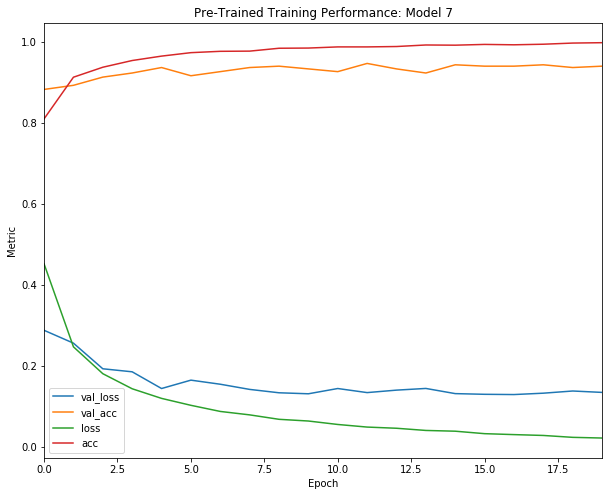

In [19]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=5e-6),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))
model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')
count += 1
plt.show()

This model trained well, but again we can't seem to break that 0.12 loss. It's possible that our models are maxed out with the given data. We will bring each model into testing and utilize the model with the highest test accuracy.

## Model Testing

Let's get each of our models and load them. 

In [21]:
print(os.listdir('models'))

['model_01.h5', 'model_VGG_01.h5', 'model_VGG_02.h5', 'model_VGG_03.h5', 'model_VGG_04.h5', 'model_VGG_05.h5', 'model_VGG_06.h5', 'model_VGG_07.h5']


In [23]:
model_scratch = load_model('models/' + os.listdir('models')[0])
models_VGG = {model: load_model('models/' + model) for model in os.listdir('models')[1:]}

Recall that the data we need for evaluating is different for each model. For the scratch model, we will evaluate performance using an ImageDataGenerator. For the VGG model, recall we have a preloaded numpy array containing each of the weights.

Let's first test the scratch model.

In [24]:
# Get test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                        'data/test',
                        target_size=(228, 228),
                        batch_size=16,
                        class_mode='binary')

Found 297 images belonging to 2 classes.


In [25]:
model_scratch.evaluate_generator(test_generator,
                                 steps=297 // 16)

[0.20300876897656256, 0.9201388888888888]

Very solid - we achieved roughly 92 percent accuracy on the test set. Let's now evaluate the VGG models.

In [27]:
# Get pretrained test features
test_features = np.load('data/bottlenecked/test_features.npy')
test_labels = np.load('data/bottlenecked/test_labels.npy')

In [30]:
for model_name, model in models_VGG.items():
    print(model_name  + ' Evaluation')
    print(model.evaluate(test_features, test_labels))
    print()

model_VGG_01.h5 Evaluation
297/297 [==============================] - 0s 293us/step
[0.4129591164301049, 0.9393939393939394]

model_VGG_02.h5 Evaluation
297/297 [==============================] - 0s 330us/step
[0.5212847432008457, 0.9427609427609428]

model_VGG_03.h5 Evaluation
297/297 [==============================] - 0s 296us/step
[0.2376899818547998, 0.936026936026936]

model_VGG_04.h5 Evaluation
297/297 [==============================] - 0s 343us/step
[0.18005487131211995, 0.9326599326599326]

model_VGG_05.h5 Evaluation
297/297 [==============================] - 0s 293us/step
[0.498106183406268, 0.9528619528619529]

model_VGG_06.h5 Evaluation
297/297 [==============================] - 0s 306us/step
[0.20519349023445763, 0.936026936026936]

model_VGG_07.h5 Evaluation
297/297 [==============================] - 0s 286us/step
[0.17818667277104225, 0.9326599326599326]



Our model with the highest accuracy was model_VGG_05.h5 at 95.3%. Our model with the lowest loss was model_VGG_07.5 at 0.178. The reason for this discrepency is mainly because our loss is evaluated at the probability level. Our most accurate model has more entropy, meaning that although it makes the correct > 50% predictions better than the other models, its prediction probabilities are closer to 50% than most of the other models. One way to interpret this is that it's "sureness" isn't quite as robust. Nonetheless, our best metric for model comparison is accuracy since we are mainly focused with simply being correct in identifying Clarissa. We have no preference over diminishing false positives vs. false negatives.

In [33]:
best_model = models_VGG['model_VGG_05.h5']

In [53]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 6,439,297
Trainable params: 6,439,297
Non-trainable params: 0
_________________________________________________________________


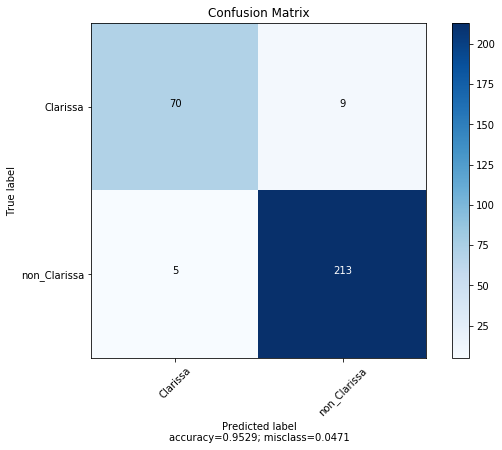

In [34]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

y_test = test_labels
# Predicts as probabilities
y_pred = best_model.predict(test_features)
y_score = np.array([int(x > 0.5) for x in y_pred])
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm, ['Clarissa', 'non_Clarissa'])

In [35]:
print("Precision Score: ", precision_score(y_test, y_score))

Precision Score:  0.9594594594594594


In [36]:
print("Recall Score: ", recall_score(y_test, y_score))

Recall Score:  0.9770642201834863


Looks good. Notice that we had a slightly higher recall than precision. Let's take a look at our roc curve.

C:\Users\rcapu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


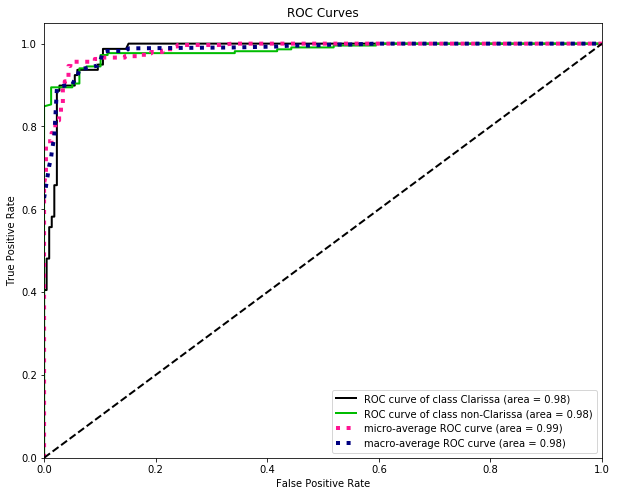

In [37]:
# Helpful package for plotting sci-kit learn stuff
import scikitplot as skplt
import matplotlib.pyplot as plt

# Note that Clarissa is represented as 0 (first folder in directory)
skplt.metrics.plot_roc_curve(['Clarissa' if x == 0 else 'non-Clarissa' for x in y_test] , 
                              np.concatenate([1 - y_pred, y_pred], axis=1), figsize=(10, 8))
plt.show()

Notice how our ROC Curves strongly stretch to the upper lefthand corner. This indicates that our true positive rate has a very small tradeoff with our false positive rate. Overall, I am very happy with this model. Our accuracy, precision, recall, and roc all look very good, especially considering we only has 512 raw photos of Clarissa to work with. An obvious way to improve performance further is to simply upload more photos, and this will certainly be a next phase of our project. For now, let's visualize some misclassifications and determine if there is a common theme.

In [38]:
test_datagen = ImageDataGenerator(rescale=1./255)
full_test_generator = test_datagen.flow_from_directory(
                        'data/test',
                        target_size=(224, 224),
                        batch_size=297,
                        class_mode='binary')

Found 297 images belonging to 2 classes.


Not Clarissa!


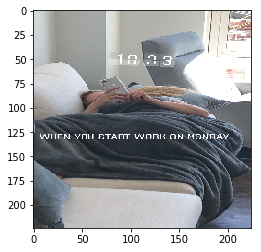


Clarissa!


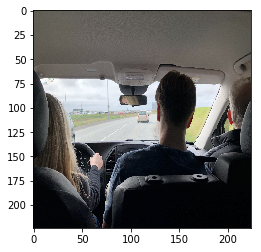


Not Clarissa!


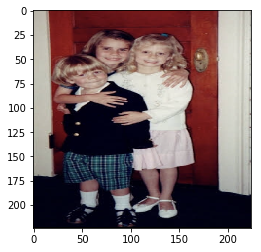


Clarissa!


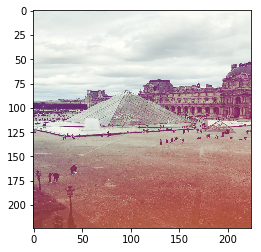


Clarissa!


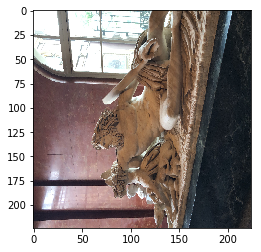


Not Clarissa!


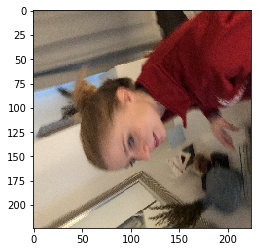


Not Clarissa!


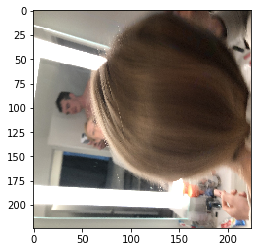


Not Clarissa!


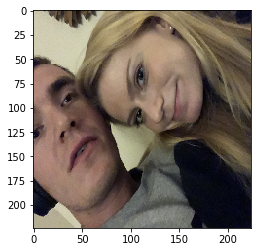


Not Clarissa!


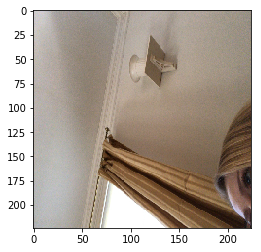


Clarissa!


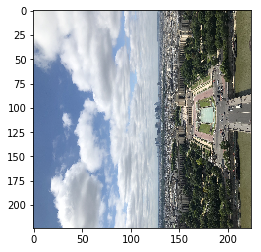


Not Clarissa!


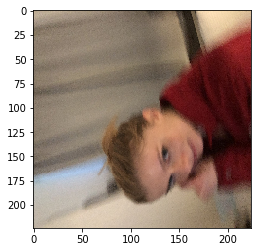


Not Clarissa!


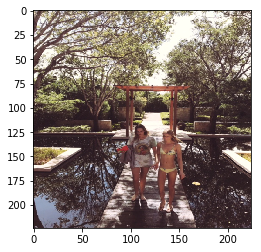


Not Clarissa!


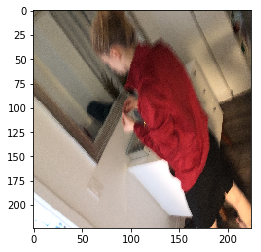


Clarissa!


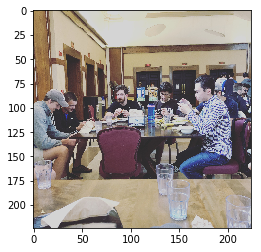

In [41]:
# Prints all misclassified images
x = next(full_test_generator)
for i in range(297):
    cnn_pred = cnn_base.predict(x[0][i].reshape(1, 224, 224, 3)).flatten().reshape(1, -1)
    full_pred = (best_model.predict(cnn_pred) >= 0.5)
    if full_pred != int(x[1][i]):
        print('Not Clarissa!' if full_pred else 'Clarissa!')
        plt.imshow(x[0][i].reshape((224, 224, 3)))
        plt.show()
        print()

It seems that on images where the true label was Clarissa and the predicted label was incorrect, the image is either blurry or a back profile. Also, there was a misclassified childhood photo, of which we have far less training data.

In the case where the true label was non-Clarissa and the predicted label was incorrect, it is difficult to say why the model thought clarissa was in the image, although most images contain some kind of human form. Overall, it is impressive that all of our other classifications were correct!

# Conclusion

In this notebook, we analyzed the problem of person detection, a very large problem in computer vision. One of the main challenges of person identification is low amounts of data per person and very noisy image data. Nonetheless, we have shown how even with small, imperfect data, we can fit a very robust model, especially when using pretrained models.

Pretraining was a huge advantage for many reasons. First of all, it gave us an immediate performance boost before tuning any hyperparameters. Secondly, it mapped our data to a much lower dimensional space, allowing us to validate new models quickly and easily. In the end, it ended up being by far the superior technique. I find it fascinating how pulling a pretrained model, one that has never even seen the photos you are feeding it, can map the image to a space that is much more informative for a final dense layer. It seems to extract the structure necessary to make meaning of the data, whereas building a convolutional model from scratch just does not have enough data to do so.

# Next Steps

As mentioned earlier, the most obvious and strongest way to improve model performance here would be to upload more pictures of Clarissa. In this project, I easily exhausted all of the photos on my own and even took more purely for this project. A main challenge is getting photos with high variance, i.e. ones in different locations with different clothes and different angles / positions. This is very challenging to synthesize as it requires a lot of effort from both parties. Nonetheless, I plan to get more photos to improve the model!